# Goal

* Analyze results from `microDivBetaDiv` simulation

# Var

In [55]:
workDir = '/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv/'

# Init

In [56]:
library(dplyr)
library(tidyr)
library(ggplot2)

as.Num = function(x) x %>% as.character %>% as.numeric

In [57]:
# classifying true positives, neg, ...
clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

# Load

In [58]:
# files on simulation accuracy
files = list.files(path=workDir, pattern='*-cMtx_byClass.txt', full.names=TRUE)
files

[1] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//DESeq2_multi-cMtx_byClass.txt"
[2] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//DESeq2-cMtx_byClass.txt"      
[3] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//heavy-cMtx_byClass.txt"       
[4] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//qSIP-cMtx_byClass.txt"

In [59]:
# combining files
df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

,library,variables,values,shared_perc,perm_perc,rep,file,method
1,2,Sensitivity,0.717171717171717,80,0,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
2,2,Specificity,0.967403958090803,80,0,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
3,2,Pos Pred Value,0.717171717171717,80,0,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi


In [60]:
# renaming methods
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'q-SIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

,library,variables,values,shared_perc,perm_perc,rep,file,method
1,2,Sensitivity,0.717171717171717,80,0,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
2,2,Specificity,0.967403958090803,80,0,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
3,2,Pos Pred Value,0.717171717171717,80,0,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP


# Incorp-call accuracy

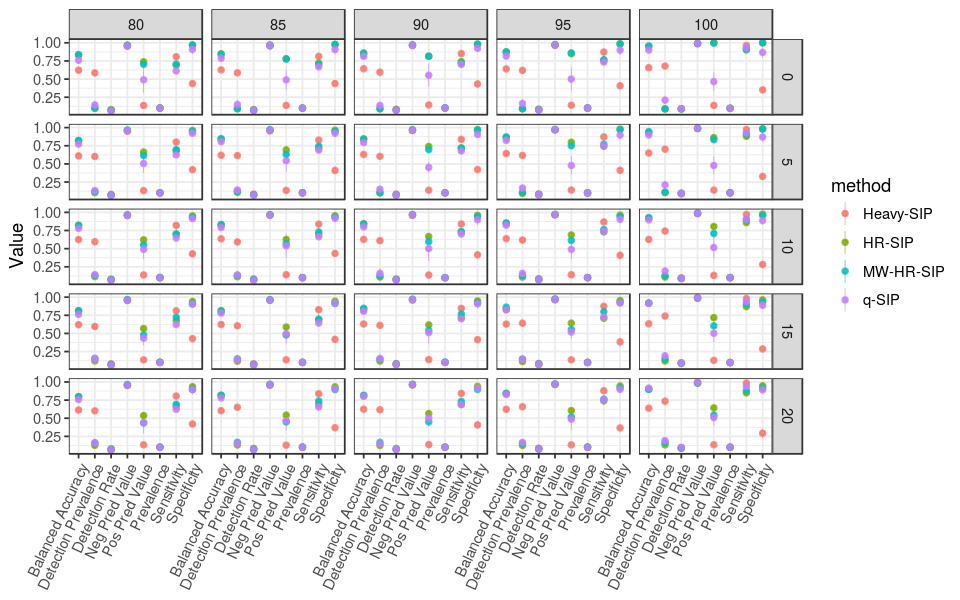

In [61]:
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, shared_perc, perm_perc, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE))

# plotting
options(repr.plot.width=8, repr.plot.height=5)
p = ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(perm_perc ~ shared_perc) +
    theme_bw() +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=65, hjust=1)
    )
plot(p)

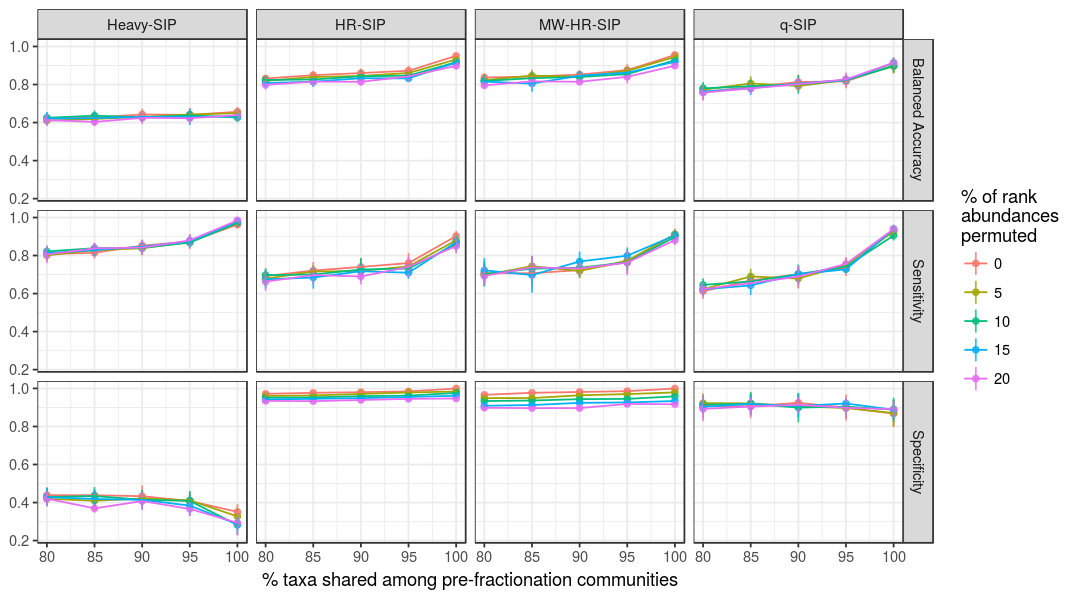

In [62]:
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(perm_perc = perm_perc %>% as.character,
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))


# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.pnt = ggplot(df_byClass.s.f, aes(shared_perc, mean_value, 
                           color=perm_perc, 
                           group=perm_perc,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared among pre-fractionation communities') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
plot(p.pnt)

In [63]:
outF = file.path(workDir, 'microBetaDiv_acc.pdf')
ggsave(outF, p.pnt, width=10, height=6)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_acc.pdf 


In [64]:
outF = file.path(workDir, 'microBetaDiv_acc.jpeg')
ggsave(outF, p.pnt, width=10, height=6)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_acc.jpeg 


# Sensitivity ~ abundance

* `sensitivity = true_positive / (true_positive + false_negative)`
* `sensitivity = true_incorporators_called_incorporators / (true_incorporators)`

## Load true BD shift

In [65]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 250


In [66]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, shared_perc, perm_perc, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE))

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 265350


,taxon,shared_perc,perm_perc,rep,median_true_BD_shift,true_incorporator
1,Acaryochloris_marina_MBIC11017,100,0,1,0,FALSE
2,Acaryochloris_marina_MBIC11017,100,0,10,0.018,TRUE
3,Acaryochloris_marina_MBIC11017,100,0,5,0,FALSE


## Loading original taxon abundances

In [67]:
comm_files = list.files(path=workDir, pattern='comm.txt', full.names=TRUE, recursive=TRUE)
comm_files %>% length %>% print

[1] 250


In [68]:
df_comm = list()
for(F in comm_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_comm[[F]] = tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)


# mean abund for libraries
df_comm = df_comm %>%
    rename('taxon' = taxon_name) %>%
    group_by(taxon, shared_perc, perm_perc, rep) %>%
    summarize(mean_rel_abund_perc = mean(rel_abund_perc),
              mean_rank_abund = mean(rank)) %>%
    ungroup()

# status
df_comm %>% nrow %>% print
df_comm %>% head(n=3)

[1] 276200


,taxon,shared_perc,perm_perc,rep,mean_rel_abund_perc,mean_rank_abund
1,Acaryochloris_marina_MBIC11017,100,0,1,0.000937175833333333,875
2,Acaryochloris_marina_MBIC11017,100,0,10,0.00209780783333333,814
3,Acaryochloris_marina_MBIC11017,100,0,5,0.0084401665,574


## Load MW-HR-SIP incorp tables

In [69]:
MW_files = list.files(path=workDir, pattern='_MW_DESeq2_incorp.txt', full.names=TRUE, recursive=TRUE)
MW_files %>% length %>% print

[1] 250


In [70]:
df_MW = list()
#for(F in MW_files){
for(F in MW_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_MW[[F]] = tmp
}

df_MW = do.call(rbind, df_MW)
rownames(df_MW) = 1:nrow(df_MW)

# status
df_MW %>% nrow %>% print
df_MW %>% head(n=3)

[1] 248660


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,p,occur_all,occur_heavy,heavy_BD_min,heavy_BD_max,taxon,incorp,shared_perc,perm_perc,rep,file
1,13.6746660415729,-0.0254740550747454,0.477784506726464,-0.0533170387823596,0.957479304525371,0.99925712189927,0.717883489066783,0.5,0,1.7,1.73,Acetobacterium_woodii_DSM_1030,FALSE,100,0,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
2,1.86161694008983,0.0352261251891091,0.491692208768513,0.0716426344792734,0.942886309820477,0.99925712189927,0.668873805144978,0.5,0,1.7,1.73,Acholeplasma_laidlawii_PG-8A,FALSE,100,0,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
3,6.77621661403903,-0.259028250885625,0.437047684165791,-0.59267732165208,0.553397121455482,0.99925712189927,0.8779292256869,0.5,0,1.7,1.73,Acidaminococcus_fermentans_DSM_20731,FALSE,100,0,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt


## group by abundance and calculate sensitivity

In [71]:
join_vars = c('taxon' = 'taxon',
              'shared_perc'='shared_perc',
              'perm_perc'='perm_perc',
              'rep'='rep')

# joining tables
df_MW %>% nrow %>% print
df.j = df_MW %>% 
    left_join(df_shift, join_vars)

df.j %>% nrow %>% print
df.j = df.j %>% 
    left_join(df_comm, join_vars)

# status
df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 248660


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 248660


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 248660


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,p,occur_all,occur_heavy,heavy_BD_min,⋯,taxon,incorp,shared_perc,perm_perc,rep,file,median_true_BD_shift,true_incorporator,mean_rel_abund_perc,mean_rank_abund
1,13.6746660415729,-0.0254740550747454,0.477784506726464,-0.0533170387823596,0.957479304525371,0.99925712189927,0.717883489066783,0.5,0,1.7,⋯,Acetobacterium_woodii_DSM_1030,FALSE,100,0,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.194092934333333,97
2,1.86161694008983,0.0352261251891091,0.491692208768513,0.0716426344792734,0.942886309820477,0.99925712189927,0.668873805144978,0.5,0,1.7,⋯,Acholeplasma_laidlawii_PG-8A,FALSE,100,0,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.0374783978333333,301
3,6.77621661403903,-0.259028250885625,0.437047684165791,-0.59267732165208,0.553397121455482,0.99925712189927,0.8779292256869,0.5,0,1.7,⋯,Acidaminococcus_fermentans_DSM_20731,FALSE,100,0,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.0719306055,205


In [72]:
# calling true_pos + false_neg
df.j = df.j %>%
    mutate(incorp_cls = mapply(clsfy, incorp, true_incorporator)) 

# status
df.j %>% nrow %>% print
df.j$incorp_cls %>% table %>% print

[1] 248660
.
False negative False positive  True negative  True positive 
          5999          12703         210683          19275 


In [73]:
# function for calculating sensitivity
calc_sensitivity = function(incorp_cls){
    tp = sum(incorp_cls == 'True positive')
    fn = sum(incorp_cls == 'False negative')
    x = tp / (tp + fn)
    ifelse(is.na(x), 0, x)
}

# grouping by abundance and calculating sensitivity
df.j.s = df.j %>%
    mutate(n_group = ntile(log10(mean_rel_abund_perc), 10)) %>%
    group_by(n_group, shared_perc, perm_perc, rep) %>%
    summarize(min_abund = min(mean_rel_abund_perc, na.rm=TRUE),
              mean_abund = mean(mean_rel_abund_perc, na.rm=TRUE),
              max_abund = max(mean_rel_abund_perc, na.rm=TRUE),
              sensitivity = calc_sensitivity(incorp_cls)) %>%
    group_by(n_group, shared_perc, perm_perc) %>%
    summarize(mean_abund = mean(mean_abund),
              mean_sensitivity = mean(sensitivity),
              sd_sensitivity = sd(sensitivity)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% as.character,
           shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% as.character,
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))

# status
df.j.s %>% head(n=3)

,n_group,shared_perc,perm_perc,mean_abund,mean_sensitivity,sd_sensitivity
1,1,100,0,0.000762758835330622,0.543694083694084,0.143265051367545
2,1,100,10,0.000792949240980225,0.500555555555556,0.234121244661065
3,1,100,15,0.000851199204958537,0.611904761904762,0.274114162253791


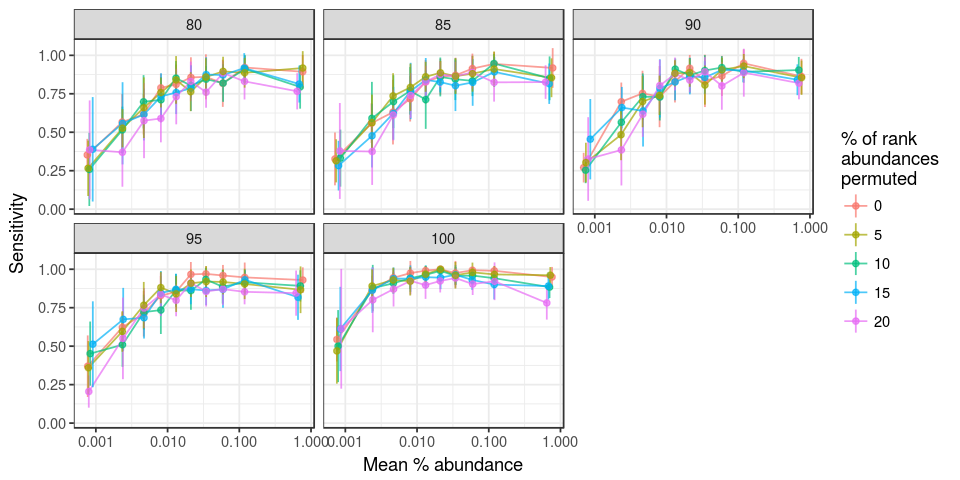

In [74]:
# plotting
options(repr.plot.width=8, repr.plot.height=4)
p_sens_abund = ggplot(df.j.s, aes(mean_abund, mean_sensitivity, 
                                  color=perm_perc,
                                  ymin=mean_sensitivity-sd_sensitivity,
                                  ymax=mean_sensitivity+sd_sensitivity)) +
    geom_line(alpha=0.7) +
    geom_linerange(alpha=0.7) +
    geom_point(alpha=0.7) +
    scale_x_log10(breaks=c(1e-3, 1e-2, 1e-1, 1e0)) +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='Mean % abundance',
         y='Sensitivity') +
    facet_wrap(~ shared_perc) +
    theme_bw()

p_sens_abund

In [75]:
outF = file.path(workDir, 'microBetaDiv_sens-abund.pdf')
ggsave(outF, p_sens_abund, width=10, height=5)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_sens-abund.pdf 


In [76]:
outF = file.path(workDir, 'microBetaDiv_sens-abund.jpeg')
ggsave(outF, p_sens_abund, width=10, height=5)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_sens-abund.jpeg 


# accuracy ~ pre-fractionation Bray-Curtis

* mean Bray-Curtis among replicates

In [77]:
betaDiv_files = list.files(path=workDir, pattern='comm_betaDiv.txt', full.names=TRUE, recursive=TRUE)
betaDiv_files %>% length %>% print

[1] 250


In [78]:
df_beta = list()
for(F in betaDiv_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    df_beta[[F]] = tmp
}

df_beta = do.call(rbind, df_beta)
rownames(df_beta) = 1:nrow(df_beta)

# status
df_beta %>% head(n=3)

,library_x,library_y,bray,shared_perc,perm_perc,rep
1,1,2,0.147932373867752,100,0,1
2,1,3,0.177806469871777,100,0,1
3,1,4,0.103557942446214,100,0,1


In [79]:
# mean bray per parameter set
df_beta_s = df_beta %>%
    group_by(shared_perc, perm_perc, rep) %>%
    summarize(mean_BC = mean(bray)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% as.Num,
           perm_perc = perm_perc %>% as.Num, 
           rep = rep %>% as.Num)
# status
df_beta_s %>% head(n=3)

,shared_perc,perm_perc,rep,mean_BC
1,100.0000000,0.0000000,1.0000000,0.1446466
2,100.00000000,0.00000000,10.00000000,0.08220454
3,100.0000000,0.0000000,2.0000000,0.1233774


In [80]:
# confusion matrix data
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')

df_byClass.f = df_byClass %>%
    filter(variables %in% vars) %>%
    mutate(shared_perc = shared_perc %>% as.Num,
           perm_perc = perm_perc %>% as.Num,
           rep = rep %>% as.Num)

df_byClass.f.j = inner_join(df_byClass.f, df_beta_s, 
                            c('shared_perc'='shared_perc',
                              'perm_perc'='perm_perc',
                              'rep'='rep')) %>%
    #filter(variables == 'Balanced Accuracy') %>%
    mutate(perm_perc = perm_perc %>% as.character,
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric),
           shared_perc = shared_perc %>% as.character,
           shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric))
    
# status
df_byClass.f %>% head(n=3)

,library,variables,values,shared_perc,perm_perc,rep,file,method
1,2,Sensitivity,0.717171717171717,80,0,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
2,2,Specificity,0.967403958090803,80,0,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
3,2,Balanced Accuracy,0.84228783763126,80,0,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP


`geom_smooth()` using method = 'loess'


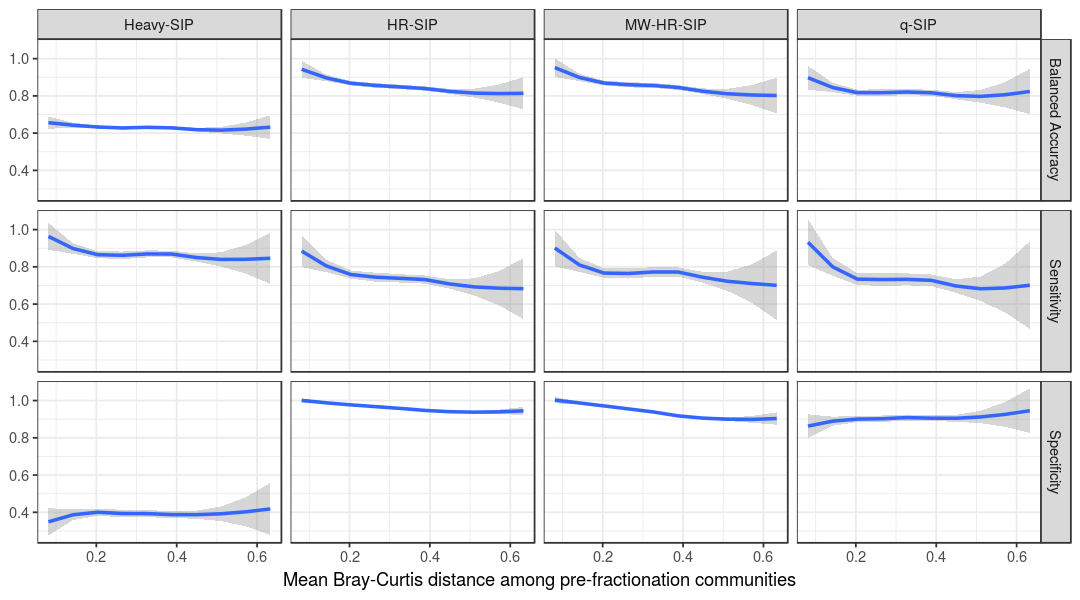

In [81]:
# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.betadiv = ggplot(df_byClass.f.j %>% filter(library==6), aes(mean_BC, values)) +
    stat_smooth(level=0.99, n=10) +
    labs(x='Mean Bray-Curtis distance among pre-fractionation communities') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
p.betadiv

In [82]:
outF = file.path(workDir, 'microBetaDiv_bc-smooth.pdf')
ggsave(outF, p.betadiv, width=10, height=6)
cat('File written:', outF, '\n')

`geom_smooth()` using method = 'loess'


File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_bc-smooth.pdf 


In [83]:
outF = file.path(workDir, 'microBetaDiv_bc-smooth.jpeg')
ggsave(outF, p.betadiv, width=10, height=6)
cat('File written:', outF, '\n')

`geom_smooth()` using method = 'loess'


File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_bc-smooth.jpeg 


# BD shift quantify

## True BD shift

In [84]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 250


In [85]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, shared_perc, perm_perc, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) 

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 265350


,taxon,shared_perc,perm_perc,rep,median_true_BD_shift
1,Acaryochloris_marina_MBIC11017,100,0,1,0
2,Acaryochloris_marina_MBIC11017,100,0,10,0.018
3,Acaryochloris_marina_MBIC11017,100,0,5,0


## MW-HR-SIP incorp calls

* filtering BD shift estimates to just incorporators identified by MW-HR-SIP

In [86]:
incorp_files = list.files(path=workDir, pattern='OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt', full.names=TRUE, recursive=TRUE)
incorp_files %>% length %>% print

[1] 250


In [87]:
df_incorp = list()
for(F in incorp_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_incorp[[F]] = tmp
}

df_incorp = do.call(rbind, df_incorp)
rownames(df_incorp) = 1:nrow(df_incorp)
df_incorp %>% head(n=3) %>% print

   baseMean log2FoldChange     lfcSE        stat    pvalue      padj         p
1 13.674666    -0.02547406 0.4777845 -0.05331704 0.9574793 0.9992571 0.7178835
2  1.861617     0.03522613 0.4916922  0.07164263 0.9428863 0.9992571 0.6688738
3  6.776217    -0.25902825 0.4370477 -0.59267732 0.5533971 0.9992571 0.8779292
  occur_all occur_heavy heavy_BD_min heavy_BD_max
1       0.5           0          1.7         1.73
2       0.5           0          1.7         1.73
3       0.5           0          1.7         1.73
                                 taxon incorp shared_perc perm_perc rep
1       Acetobacterium_woodii_DSM_1030  FALSE         100         0   1
2         Acholeplasma_laidlawii_PG-8A  FALSE         100         0   1
3 Acidaminococcus_fermentans_DSM_20731  FALSE         100         0   1
                                          file
1 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
2 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
3 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt


In [88]:
# just incorporators
df_incorp = df_incorp %>%
    filter(incorp == TRUE) %>%
    dplyr::distinct(taxon, incorp, shared_perc, perm_perc, rep) %>%
    rename('HWHRSIP_incorp' = incorp)

df_incorp %>% nrow %>% print
df_incorp %>% head(n=3) %>% print

[1] 31978
                                   taxon HWHRSIP_incorp shared_perc perm_perc
1 Campylobacter_insulaenigrae_NCTC_12927           TRUE         100         0
2   Acidobacterium_capsulatum_ATCC_51196           TRUE         100         0
3           Agrobacterium_fabrum_str_C58           TRUE         100         0
  rep
1   1
2   1
3   1


## q-SIP

In [89]:
atomX_files = list.files(path=workDir, pattern='*_qSIP_atom.txt', full.names=TRUE, recursive=TRUE)
atomX_files %>% length %>% print

[1] 250


In [90]:
df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3) %>% print

                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017 1.722028  1.708890 -0.013138045
2 Acetobacter_pasteurianus_IFO_3283-03 1.710307  1.712948  0.002640978
3       Acetobacterium_woodii_DSM_1030 1.704576  1.703236 -0.001340461
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.9097708   308.1422         317.6631     305.7913          -0.24418197
2  0.7694042   308.0726         317.6635     308.5483           0.04904946
3  0.7007802   308.0386         317.6637     307.7963          -0.02488779
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.600857174   0.10884380         100         0   1
2 -0.004524922   0.09510114         100         0   1
3 -0.039247999  -0.01162916         100         0   1
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


### Joining estimate with true values

In [91]:
# table join
df_atomX %>% nrow %>% print

df.j = left_join(df_atomX, df_shift, c('taxon' = 'taxon',
                                       'shared_perc'='shared_perc',
                                       'perm_perc'='perm_perc',
                                       'rep'='rep')) %>%
   filter(!is.na(BD_diff)) %>%
   mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
          true_atom_fraction_excess = median_true_BD_shift / 0.036,
          atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

[1] 276200


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 203945
                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017 1.722028  1.708890 -0.013138045
2 Acetobacter_pasteurianus_IFO_3283-03 1.710307  1.712948  0.002640978
3       Acetobacterium_woodii_DSM_1030 1.704576  1.703236 -0.001340461
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.9097708   308.1422         317.6631     305.7913          -0.24418197
2  0.7694042   308.0726         317.6635     308.5483           0.04904946
3  0.7007802   308.0386         317.6637     307.7963          -0.02488779
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.600857174   0.10884380         100         0   1
2 -0.004524922   0.09510114         100         0   1
3 -0.039247999  -0.01162916         100         0   1
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt       

In [92]:
df.j$true_incorporator %>% summary

   Mode   FALSE    TRUE    NA's 
logical  183676   20269       0 

### Joining with MW-HR-SIP

In [93]:
df.j = left_join(df.j, df_incorp, c('taxon' = 'taxon',
                                    'shared_perc'='shared_perc',
                                    'perm_perc'='perm_perc',
                                    'rep'='rep')) %>%
    mutate(HWHRSIP_incorp = ifelse(is.na(HWHRSIP_incorp), FALSE, TRUE))

df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 203945
                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017 1.722028  1.708890 -0.013138045
2 Acetobacter_pasteurianus_IFO_3283-03 1.710307  1.712948  0.002640978
3       Acetobacterium_woodii_DSM_1030 1.704576  1.703236 -0.001340461
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.9097708   308.1422         317.6631     305.7913          -0.24418197
2  0.7694042   308.0726         317.6635     308.5483           0.04904946
3  0.7007802   308.0386         317.6637     307.7963          -0.02488779
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.600857174   0.10884380         100         0   1
2 -0.004524922   0.09510114         100         0   1
3 -0.039247999  -0.01162916         100         0   1
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt       

### Plotting results

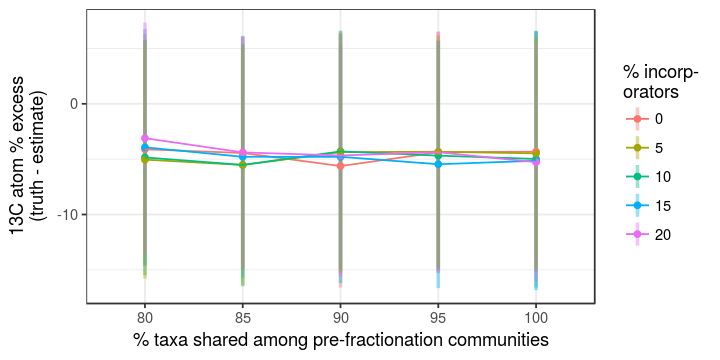

In [94]:
# difference between true and estimated

## q-SIP incorporators 
df.j.dis.qSIP = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))
   
# plotting
options(repr.plot.width=6, repr.plot.height=3)
p_qSIP = ggplot(df.j.dis.qSIP, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    geom_line() +
    #facet_grid(true_incorporator ~ .) +
    scale_color_discrete('% incorp-\norators') +
    labs(x='% taxa shared among pre-fractionation communities', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

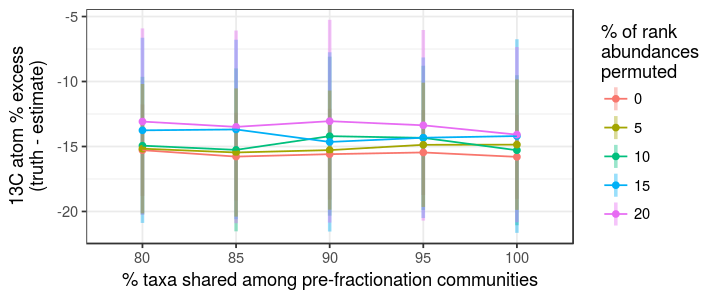

In [95]:
# difference between true and estimated

## q-SIP incorporators 
df.j.dis.qSIP = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))
   
# plotting
options(repr.plot.width=6, repr.plot.height=2.5)
p_qSIP = ggplot(df.j.dis.qSIP, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    geom_line() +
    #facet_grid(true_incorporator ~ .) +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared among pre-fractionation communities', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

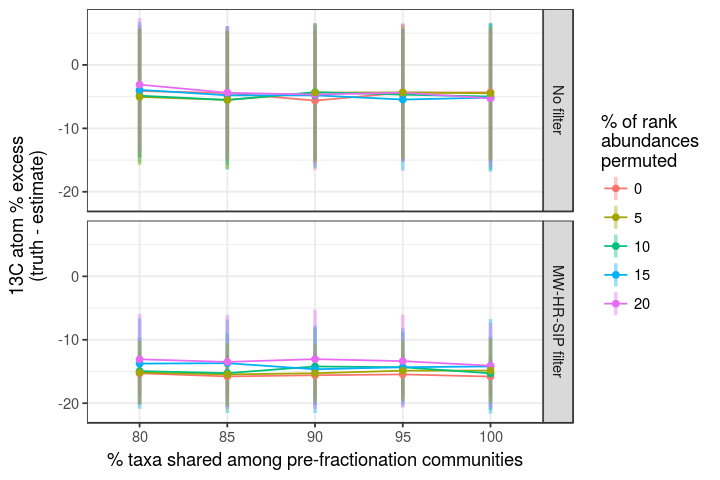

In [96]:
# difference between true and estimated
## q-SIP incorporators 
tmp1 = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric),
           incorp_called = 'No filter')
## MW-HR-SIP incorporators
tmp2 = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric),
           incorp_called = 'MW-HR-SIP filter')

# combining tables
df.j.dis.qSIP = rbind(tmp1, tmp2) %>%
    mutate(incorp_called = factor(incorp_called, levels=c('No filter', 'MW-HR-SIP filter')))

   
# plotting
options(repr.plot.width=6, repr.plot.height=4)
p_qSIP = ggplot(df.j.dis.qSIP, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    facet_grid(incorp_called ~ .) +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared among pre-fractionation communities', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

## delta-BD

In [97]:
dBD_files = list.files(path=workDir, pattern='*_dBD.txt', full.names=TRUE, recursive=TRUE)
dBD_files %>% length %>% print

[1] 250


In [98]:
df_dBD = list()
for(F in dBD_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$shared_perc = FF[FFl-3]
    tmp$perm_perc = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_dBD[[F]] = tmp
}

df_dBD = do.call(rbind, df_dBD)
rownames(df_dBD) = 1:nrow(df_dBD)
df_dBD %>% head(n=3) %>% print

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.729906          1.706919
2 Acetobacter_pasteurianus_IFO_3283-03        1.721156          1.721987
3       Acetobacterium_woodii_DSM_1030        1.714703          1.709346
  stdev_CM_control stdev_CM_treatment      delta_BD shared_perc perm_perc rep
1      0.020665026       0.0021992188 -0.0229868245         100         0   1
2      0.002170362       0.0092936484  0.0008304907         100         0   1
3      0.001507780       0.0005208017 -0.0053571403         100         0   1
                        file
1 OTU_abs1e9_PCR_sub_dBD.txt
2 OTU_abs1e9_PCR_sub_dBD.txt
3 OTU_abs1e9_PCR_sub_dBD.txt


### Joining estimate with truth

In [99]:
df.j = inner_join(df_dBD, df_shift, c('taxon' = 'taxon',
                                       'shared_perc'='shared_perc',
                                       'perm_perc'='perm_perc',
                                       'rep'='rep')) %>%
    filter(!is.na(delta_BD)) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = delta_BD / 0.036)
df.j %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

,taxon,mean_CM_control,mean_CM_treatment,stdev_CM_control,stdev_CM_treatment,delta_BD,shared_perc,perm_perc,rep,file,median_true_BD_shift,true_incorporator,true_atom_fraction_excess,atom_fraction_excess
1,Acaryochloris_marina_MBIC11017,1.729906072,1.7069192475,0.0206650261538,0.00219921880986,-0.0229868244981,100,0,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.638522902725
2,Acetobacter_pasteurianus_IFO_3283-03,1.72115641726,1.72198690793,0.00217036246995,0.00929364841039,0.000830490670569,100,0,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.0230691852935833
3,Acetobacterium_woodii_DSM_1030,1.71470324574,1.70934610548,0.00150778021095,0.000520801727452,-0.00535714026073,100,0,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.148809451686944


### Joining with MW-HR-SIP

In [100]:
df.j = left_join(df.j, df_incorp, c('taxon' = 'taxon',
                                    'shared_perc'='shared_perc',
                                    'perm_perc'='perm_perc',
                                    'rep'='rep')) %>%
    mutate(HWHRSIP_incorp = ifelse(is.na(HWHRSIP_incorp), FALSE, TRUE))

df.j %>% nrow %>% print
df.j %>% head(n=3)

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 265350


,taxon,mean_CM_control,mean_CM_treatment,stdev_CM_control,stdev_CM_treatment,delta_BD,shared_perc,perm_perc,rep,file,median_true_BD_shift,true_incorporator,true_atom_fraction_excess,atom_fraction_excess,HWHRSIP_incorp
1,Acaryochloris_marina_MBIC11017,1.729906072,1.7069192475,0.0206650261538,0.00219921880986,-0.0229868244981,100,0,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.638522902725,FALSE
2,Acetobacter_pasteurianus_IFO_3283-03,1.72115641726,1.72198690793,0.00217036246995,0.00929364841039,0.000830490670569,100,0,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.0230691852935833,FALSE
3,Acetobacterium_woodii_DSM_1030,1.71470324574,1.70934610548,0.00150778021095,0.000520801727452,-0.00535714026073,100,0,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.148809451686944,FALSE


### Plotting results

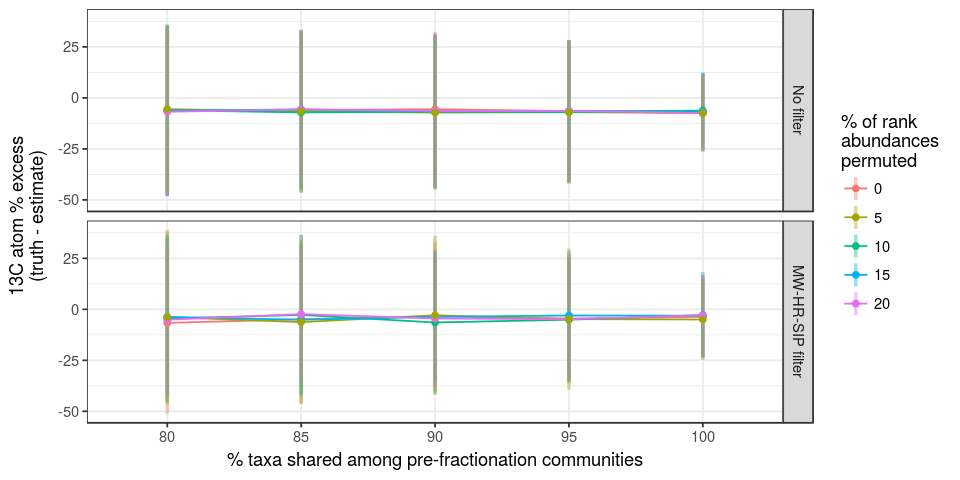

In [101]:
# difference between true and estimated
tmp1 = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric),
           incorp_called = 'No filter')

tmp2 = df.j %>%
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric),
           incorp_called = 'MW-HR-SIP filter')

   
# combining tables
df.j.dis.dBD = rbind(tmp1, tmp2) %>%
    mutate(incorp_called = factor(incorp_called, levels=c('No filter', 'MW-HR-SIP filter')))


# plotting
options(repr.plot.width=8, repr.plot.height=4)
p_dBD = ggplot(df.j.dis.dBD, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    facet_grid(incorp_called ~ .) +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared among pre-fractionation communities', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_dBD 

## Combined plot

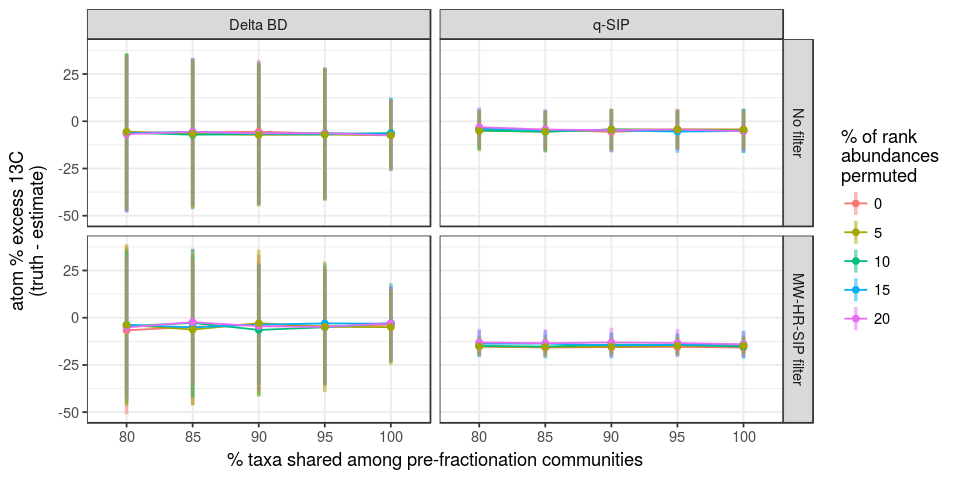

In [102]:
df.jj = rbind(df.j.dis.qSIP %>% mutate(method='qSIP'),
              df.j.dis.dBD %>% mutate(method='Delta BD')) %>%
    mutate(method = gsub('qSIP', 'q-SIP', method))


p.comb = ggplot(df.jj, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.5, size=1) +
    geom_point() +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared among pre-fractionation communities', 
         y='atom % excess 13C\n(truth - estimate)') +
    facet_grid(incorp_called ~ method) +
    theme_bw() 
p.comb

In [103]:
outF = file.path(workDir, 'microBetaDiv_BDshift.pdf')
ggsave(outF, p.comb, width=8, height=4)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_BDshift.pdf 


In [104]:
outF = file.path(workDir, 'microBetaDiv_BDshift.jpeg')
ggsave(outF, p.comb, width=8, height=4)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/microBetaDiv//microBetaDiv_BDshift.jpeg 
